In [11]:
import h5py
import scipy.io as io
from PIL import Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
#from image import *
import shutil

In [2]:
def gaussian_filter_density(gt):
    #Generates a density map using Gaussian filter transformation
    
    density = np.zeros(gt.shape, dtype=np.float32)
    
    gt_count = np.count_nonzero(gt)
    
    if gt_count == 0:
        return density

    # FInd out the K nearest neighbours using a KDTree
    
    pts = np.array(list(zip(np.nonzero(gt)[1].ravel(), np.nonzero(gt)[0].ravel())))
    leafsize = 2048
    
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    
    # query kdtree
    distances, locations = tree.query(pts, k=4)

        
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        
        #Convolve with the gaussian filter
        
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    
    return density

In [2]:
root = 'data'

In [4]:
all_frames = os.path.join(root,'frames','images')
path_sets = [all_frames]

In [5]:
matfile = os.path.join(root,'frames','mall_gt.mat')

In [6]:
path_sets

['data\\frames\\images']

In [7]:
# List of all image paths

img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
print(len(img_paths))

2000


In [8]:
from tqdm import tqdm
# Load sparse matrix
mat = io.loadmat(matfile)
i = 0
j = 0
img_size = (480, 640)
for img_path in tqdm(img_paths):
        
    
    # Load sparse matrix
    # mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    
    #Read image
    # img= plt.imread(img_path)
    
    # Create a zero matrix of image size
    k = np.zeros(img_size)
    
    gt = mat["frame"][0,j][0,0][0]
    
    #Generate hot encoded matrix of sparse matrix
    for i in range(0,len(gt)):
        if int(gt[i][1])<img_size[0] and int(gt[i][0])<img_size[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    
    # generate density map
    k = gaussian_filter_density(k)
    
    # File path to save density map
    file_path = img_path.replace('.jpg','.h5').replace('images','ground')
    
    
    with h5py.File(file_path, 'w') as hf:
            hf['density'] = k
    j += 1
    


100%|██████████| 2000/2000 [30:26<00:00,  1.09it/s]


In [9]:
file_path = img_paths[999].replace('.jpg','.h5').replace('images','ground') 
print(file_path)

data\frames\ground\seq_001000.h5


Sum =  35.903954


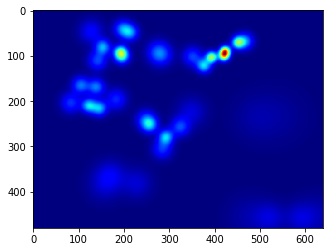

In [10]:
#Sample Ground Truth
gt_file = h5py.File(file_path,'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)
print("Sum = " ,np.sum(groundtruth))

data\frames\images\seq_001000.jpg


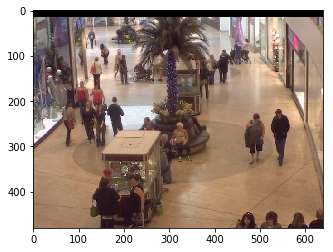

In [11]:
# Image corresponding to the ground truth
img = Image.open(file_path.replace('.h5','.jpg').replace('ground','images'))
plt.imshow(img)
print(file_path.replace('.h5','.jpg').replace('ground','images'))

In [12]:
# creating train and test data
os.makedirs(os.path.join(root, 'frames', 'train_data', 'images'), exist_ok=True)
os.makedirs(os.path.join(root, 'frames', 'test_data', 'images'), exist_ok=True)
os.makedirs(os.path.join(root, 'frames', 'train_data', 'ground'), exist_ok=True)
os.makedirs(os.path.join(root, 'frames', 'test_data', 'ground'), exist_ok=True)

In [29]:
all_frames = os.path.join(root,'frames','images')
image_files = [f for f in os.listdir(all_frames) if f.endswith(".jpg")]
print(len(image_files))

2000


In [30]:
# Calculate the number of images to put in the train and test folders
num_train_images = int(0.8 * len(image_files))
num_test_images = len(image_files) - num_train_images

In [31]:
print(num_train_images, num_test_images)

1600 400


In [32]:
# Split the list of image files into train and test sets
train_images = image_files[:num_train_images]
test_images = image_files[num_train_images:]

In [33]:
train_image_dir = os.path.join(root, 'frames', 'train_data', 'images')
test_image_dir = os.path.join(root, 'frames', 'test_data', 'images')
train_ground_dir = os.path.join(root, 'frames', 'train_data', 'ground')
test_ground_dir = os.path.join(root, 'frames', 'test_data', 'ground')

In [34]:
train_image_dir

'data\\frames\\train_data\\images'

In [36]:
# Copy the images from the data folder to the train and test folders
for image in train_images:
    source = os.path.join(all_frames, image)
    destination = os.path.join(train_image_dir, image)
    shutil.copy2(source, destination)

for image in test_images:
    source = os.path.join(all_frames, image)
    destination = os.path.join(test_image_dir, image)
    shutil.copy2(source, destination)

In [38]:
all_gd = os.path.join(root,'frames','ground')

In [39]:
# Copy the original density maps from the data folder to the train and test folders
for image in train_images:
    source = os.path.join(all_gd, image.replace('.jpg','.h5'))
    destination = os.path.join(train_ground_dir, image.replace('.jpg','.h5'))
    shutil.copy2(source, destination)

for image in test_images:
    source = os.path.join(all_gd, image.replace('.jpg','.h5'))
    destination = os.path.join(test_ground_dir, image.replace('.jpg','.h5'))
    shutil.copy2(source, destination)